In [39]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, BitsAndBytesConfig, TrainingArguments, Trainer, get_linear_schedule_with_warmup
from datasets import load_dataset, concatenate_datasets, Dataset

from peft import get_peft_config, get_peft_model, prepare_model_for_kbit_training, PeftConfig

from accelerate import Accelerator

import torch
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd

import os
import sys
sys.path.append(os.getcwd()+"/../..")

from src import paths

from tqdm import tqdm

import evaluate 

In [56]:
generated_ppms = pd.read_csv(paths.DATA_PATH_PREPROCESSED/'ms-diag/artificial_ppms.csv')
generated_ppms["labels"] = 'primary_progressive_multiple_sclerosis'
generated_spms = pd.read_csv(paths.DATA_PATH_PREPROCESSED/'ms-diag/artificial_spms.csv')
generated_spms["labels"] = 'secondary_progressive_multiple_sclerosis'
generated_samples = pd.concat([generated_ppms, generated_spms])
generated_samples = generated_samples[["0", "labels"]].rename(columns = {"0":"text"})
generated_samples = Dataset.from_pandas(generated_samples).remove_columns('__index_level_0__')

In [59]:
# Load data
data_files = {"train": "ms-diag_clean_train.csv", "validation": "ms-diag_clean_val.csv", "test": "ms-diag_clean_test.csv"}
df = load_dataset(os.path.join(paths.DATA_PATH_PREPROCESSED,'ms-diag'), data_files = data_files)
df["train"] = concatenate_datasets([generated_samples, df["train"]])

# Number of labels
num_labels = len(set(df['train']['labels']))

# Label to id
label2id = {'primary_progressive_multiple_sclerosis': 0,
            'relapsing_remitting_multiple_sclerosis': 1,
            'secondary_progressive_multiple_sclerosis': 2}
id2label = {v:k for k,v in label2id.items()}

In [60]:
df

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'rid', 'date'],
        num_rows: 383
    })
    validation: Dataset({
        features: ['rid', 'date', 'labels', 'text'],
        num_rows: 14
    })
    test: Dataset({
        features: ['rid', 'date', 'labels', 'text'],
        num_rows: 59
    })
})

In [17]:
bnb_config = BitsAndBytesConfig(load_in_4bit=True,
                                        bnb_4bit_use_double_quant=True,
                                        bnb_4bit_quant_type="nf4",
                                        bnb_4bit_compute_dtype=torch.bfloat16,
                                        )

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(paths.MODEL_PATH/'medbert')

# Load model
model = AutoModelForSequenceClassification.from_pretrained(paths.MODEL_PATH/'medbert', num_labels=num_labels, torch_dtype=torch.bfloat16)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /cluster/dataset/midatams/inf-extr/resources/models/medbert and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
# For quantized training need to prepare model
# model = prepare_model_for_kbit_training(model)
config = {
    "peft_type": "PREFIX_TUNING",
    "task_type": "SEQ_CLS",
    "inference_mode": False,
    "num_virtual_tokens": 20,
    "token_dim": model.config.hidden_size,
    "num_transformer_submodules": 1,
    "num_attention_heads": model.config.num_attention_heads,
    "num_layers": model.config.num_hidden_layers,
    "encoder_hidden_size": 128,
    "prefix_projection": True,
}
peft_config = get_peft_config(config)
print(peft_config)
peft_model = get_peft_model(model, peft_config)

PrefixTuningConfig(peft_type=<PeftType.PREFIX_TUNING: 'PREFIX_TUNING'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='SEQ_CLS', inference_mode=False, num_virtual_tokens=20, token_dim=768, num_transformer_submodules=1, num_attention_heads=8, num_layers=12, encoder_hidden_size=128, prefix_projection=True)


In [62]:
# Trainable parameters
peft_model.print_trainable_parameters()
for name, param in peft_model.named_parameters():
    if param.requires_grad:
        print(name, "Shape:",param.shape)

trainable params: 2,493,827 || all params: 111,577,478 || trainable%: 2.235063065325782
base_model.classifier.modules_to_save.default.weight Shape: torch.Size([3, 768])
base_model.classifier.modules_to_save.default.bias Shape: torch.Size([3])
prompt_encoder.default.embedding.weight Shape: torch.Size([20, 768])
prompt_encoder.default.transform.0.weight Shape: torch.Size([128, 768])
prompt_encoder.default.transform.0.bias Shape: torch.Size([128])
prompt_encoder.default.transform.2.weight Shape: torch.Size([18432, 128])
prompt_encoder.default.transform.2.bias Shape: torch.Size([18432])


In [63]:
# Prepare dataset
if getattr(tokenizer, "pad_token_id") is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id


def tokenize_function(examples):
    # We need space for the prefixes, so if the sequence is longer/equal than the max model length we need to truncate to tokenizer.model_max_length - peft_config.num_virtual_tokens
    outputs = tokenizer(examples["text"], truncation=True, max_length=64)
    outputs["labels"] = [label2id[label] for label in examples["labels"]]
    return outputs

encoded_dataset = df.map(tokenize_function, batched=True, remove_columns=["text", "rid", "date"])

Map:   0%|          | 0/383 [00:00<?, ? examples/s]

Map:   0%|          | 0/14 [00:00<?, ? examples/s]

Map:   0%|          | 0/59 [00:00<?, ? examples/s]

In [64]:
# Hyperparameters
train_batch_size = 32
eval_batch_size = 12
learning_rate = 1e-5
num_epochs = 32
gradient_accumulation_steps = 1

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [45]:
# Small train dataset with balanced classes
rmms_id = label2id['relapsing_remitting_multiple_sclerosis']
small_train_dataset = concatenate_datasets([encoded_dataset['train'].filter(lambda example: example['labels'] != rmms_id), encoded_dataset['train'].filter(lambda example: example['labels'] == rmms_id).shuffle(seed=42).select(range(10))])

In [65]:
# Prepare data collator
data_collator = DataCollatorWithPadding(tokenizer, padding="longest")

# DataLoaders creation
train_dataloader = DataLoader(
    encoded_dataset["train"], shuffle=True, collate_fn=data_collator, batch_size=train_batch_size,
)
eval_dataloader = DataLoader(
    encoded_dataset["validation"], shuffle=False, collate_fn=data_collator, batch_size=eval_batch_size
)

In [66]:
# Optimizer
optimizer = torch.optim.AdamW(peft_model.parameters(), lr=learning_rate)

lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

# Loss
# Class weights
power = 1
class_weights = [1/np.log(len(encoded_dataset['train'].filter(lambda example: example['labels'] == label))) for label in set(encoded_dataset['train']['labels'])]
class_weights = [weight**power for weight in class_weights]
class_weights = torch.tensor(class_weights, dtype=model.dtype).detach().to(device)


loss_fun = torch.nn.CrossEntropyLoss(weight=class_weights)

Filter:   0%|          | 0/383 [00:00<?, ? examples/s]

Filter:   0%|          | 0/383 [00:00<?, ? examples/s]

Filter:   0%|          | 0/383 [00:00<?, ? examples/s]

In [67]:
# Seed
torch.manual_seed(42)

# Training
peft_model = peft_model.to("cuda")

for epoch in range(num_epochs):
    peft_model.train()
    total_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        # loss = loss_fun(logits, batch['labels'])
        loss = outputs.loss
        total_loss += loss.detach().float()

        loss = loss / gradient_accumulation_steps
        loss.backward()
        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            lr_scheduler.step()

    model.eval()
    eval_loss = 0
    eval_preds = []
    for step, batch in enumerate(tqdm(eval_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        eval_loss += loss.detach().float()

    eval_epoch_loss = eval_loss / len(eval_dataloader)
    train_epoch_loss = total_loss / len(train_dataloader)
    print(f"{epoch=}: {train_epoch_loss=} {eval_epoch_loss=}")

100%|██████████| 2/2 [00:00<00:00, 30.25it/s]


epoch=0: train_epoch_loss=tensor(1.1634, device='cuda:0') eval_epoch_loss=tensor(1.1094, device='cuda:0')


100%|██████████| 2/2 [00:00<00:00, 29.94it/s]


epoch=1: train_epoch_loss=tensor(1.1647, device='cuda:0') eval_epoch_loss=tensor(1.1094, device='cuda:0')


100%|██████████| 2/2 [00:00<00:00, 29.69it/s]


epoch=2: train_epoch_loss=tensor(1.1562, device='cuda:0') eval_epoch_loss=tensor(1.1055, device='cuda:0')


100%|██████████| 2/2 [00:00<00:00, 29.57it/s]


epoch=3: train_epoch_loss=tensor(1.1589, device='cuda:0') eval_epoch_loss=tensor(1.1074, device='cuda:0')


100%|██████████| 2/2 [00:00<00:00, 29.83it/s]


epoch=4: train_epoch_loss=tensor(1.1576, device='cuda:0') eval_epoch_loss=tensor(1.1074, device='cuda:0')


100%|██████████| 2/2 [00:00<00:00, 29.17it/s]


epoch=5: train_epoch_loss=tensor(1.1504, device='cuda:0') eval_epoch_loss=tensor(1.1074, device='cuda:0')


100%|██████████| 2/2 [00:00<00:00, 29.05it/s]


epoch=6: train_epoch_loss=tensor(1.1536, device='cuda:0') eval_epoch_loss=tensor(1.1094, device='cuda:0')


100%|██████████| 2/2 [00:00<00:00, 28.92it/s]


epoch=7: train_epoch_loss=tensor(1.1556, device='cuda:0') eval_epoch_loss=tensor(1.1094, device='cuda:0')


100%|██████████| 2/2 [00:00<00:00, 28.93it/s]


epoch=8: train_epoch_loss=tensor(1.1504, device='cuda:0') eval_epoch_loss=tensor(1.1094, device='cuda:0')


100%|██████████| 2/2 [00:00<00:00, 28.87it/s]


epoch=9: train_epoch_loss=tensor(1.1478, device='cuda:0') eval_epoch_loss=tensor(1.1094, device='cuda:0')


100%|██████████| 2/2 [00:00<00:00, 29.12it/s]


epoch=10: train_epoch_loss=tensor(1.1549, device='cuda:0') eval_epoch_loss=tensor(1.1094, device='cuda:0')


100%|██████████| 2/2 [00:00<00:00, 28.70it/s]


epoch=11: train_epoch_loss=tensor(1.1517, device='cuda:0') eval_epoch_loss=tensor(1.1094, device='cuda:0')


100%|██████████| 2/2 [00:00<00:00, 28.85it/s]


epoch=12: train_epoch_loss=tensor(1.1484, device='cuda:0') eval_epoch_loss=tensor(1.1094, device='cuda:0')


100%|██████████| 2/2 [00:00<00:00, 28.84it/s]


epoch=13: train_epoch_loss=tensor(1.1458, device='cuda:0') eval_epoch_loss=tensor(1.1094, device='cuda:0')


100%|██████████| 2/2 [00:00<00:00, 28.82it/s]


epoch=14: train_epoch_loss=tensor(1.1497, device='cuda:0') eval_epoch_loss=tensor(1.1094, device='cuda:0')


100%|██████████| 2/2 [00:00<00:00, 28.75it/s]


epoch=15: train_epoch_loss=tensor(1.1523, device='cuda:0') eval_epoch_loss=tensor(1.1094, device='cuda:0')


100%|██████████| 2/2 [00:00<00:00, 28.74it/s]


epoch=16: train_epoch_loss=tensor(1.1504, device='cuda:0') eval_epoch_loss=tensor(1.1094, device='cuda:0')


100%|██████████| 2/2 [00:00<00:00, 28.62it/s]


epoch=17: train_epoch_loss=tensor(1.1530, device='cuda:0') eval_epoch_loss=tensor(1.1055, device='cuda:0')


100%|██████████| 2/2 [00:00<00:00, 28.78it/s]


epoch=18: train_epoch_loss=tensor(1.1380, device='cuda:0') eval_epoch_loss=tensor(1.1055, device='cuda:0')


100%|██████████| 2/2 [00:00<00:00, 28.44it/s]


epoch=19: train_epoch_loss=tensor(1.1549, device='cuda:0') eval_epoch_loss=tensor(1.1055, device='cuda:0')


100%|██████████| 2/2 [00:00<00:00, 28.33it/s]


epoch=20: train_epoch_loss=tensor(1.1445, device='cuda:0') eval_epoch_loss=tensor(1.1055, device='cuda:0')


100%|██████████| 2/2 [00:00<00:00, 30.61it/s]


epoch=21: train_epoch_loss=tensor(1.1452, device='cuda:0') eval_epoch_loss=tensor(1.1055, device='cuda:0')


100%|██████████| 2/2 [00:00<00:00, 28.51it/s]


epoch=22: train_epoch_loss=tensor(1.1432, device='cuda:0') eval_epoch_loss=tensor(1.1055, device='cuda:0')


100%|██████████| 2/2 [00:00<00:00, 28.77it/s]


epoch=23: train_epoch_loss=tensor(1.1504, device='cuda:0') eval_epoch_loss=tensor(1.1055, device='cuda:0')


100%|██████████| 2/2 [00:00<00:00, 28.50it/s]


epoch=24: train_epoch_loss=tensor(1.1478, device='cuda:0') eval_epoch_loss=tensor(1.1055, device='cuda:0')


100%|██████████| 2/2 [00:00<00:00, 28.62it/s]


epoch=25: train_epoch_loss=tensor(1.1491, device='cuda:0') eval_epoch_loss=tensor(1.1055, device='cuda:0')


100%|██████████| 2/2 [00:00<00:00, 28.60it/s]


epoch=26: train_epoch_loss=tensor(1.1497, device='cuda:0') eval_epoch_loss=tensor(1.1055, device='cuda:0')


100%|██████████| 2/2 [00:00<00:00, 28.62it/s]


epoch=27: train_epoch_loss=tensor(1.1432, device='cuda:0') eval_epoch_loss=tensor(1.1055, device='cuda:0')


100%|██████████| 2/2 [00:00<00:00, 28.63it/s]


epoch=28: train_epoch_loss=tensor(1.1471, device='cuda:0') eval_epoch_loss=tensor(1.1055, device='cuda:0')


100%|██████████| 2/2 [00:00<00:00, 28.57it/s]


epoch=29: train_epoch_loss=tensor(1.1484, device='cuda:0') eval_epoch_loss=tensor(1.1055, device='cuda:0')


100%|██████████| 2/2 [00:00<00:00, 28.43it/s]


epoch=30: train_epoch_loss=tensor(1.1413, device='cuda:0') eval_epoch_loss=tensor(1.1055, device='cuda:0')


100%|██████████| 2/2 [00:00<00:00, 28.62it/s]

epoch=31: train_epoch_loss=tensor(1.1452, device='cuda:0') eval_epoch_loss=tensor(1.1055, device='cuda:0')


In [68]:
# Inference on test set
peft_model.eval()
test_dataloader = DataLoader(
    encoded_dataset["test"], shuffle=False, collate_fn=data_collator, batch_size=eval_batch_size
)
test_preds = []
for step, batch in enumerate(tqdm(test_dataloader)):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        logits = model(**batch).logits.to(torch.float32)
    test_preds.append(logits.detach().cpu().numpy())

test_preds = np.concatenate(test_preds)
test_preds = np.argmax(test_preds, axis=1)

100%|██████████| 5/5 [00:00<00:00, 31.70it/s]


In [69]:
test_preds

array([1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1,
       2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [70]:
# Sklearn F1, precision, recall, accuracy
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay
print(f"Accuracy: {accuracy_score(encoded_dataset['test']['labels'], test_preds)}")
print(f"Precision: {precision_score(encoded_dataset['test']['labels'], test_preds, average='macro')}")
print(f"Recall: {recall_score(encoded_dataset['test']['labels'], test_preds, average='macro')}")
print(f"F1: {f1_score(encoded_dataset['test']['labels'], test_preds, average='macro')}")

Accuracy: 0.3728813559322034
Precision: 0.28980392156862744
Recall: 0.24572649572649574
F1: 0.19983619983619982


/cluster/customapps/biomed/grlab/users/eglimar/conda/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


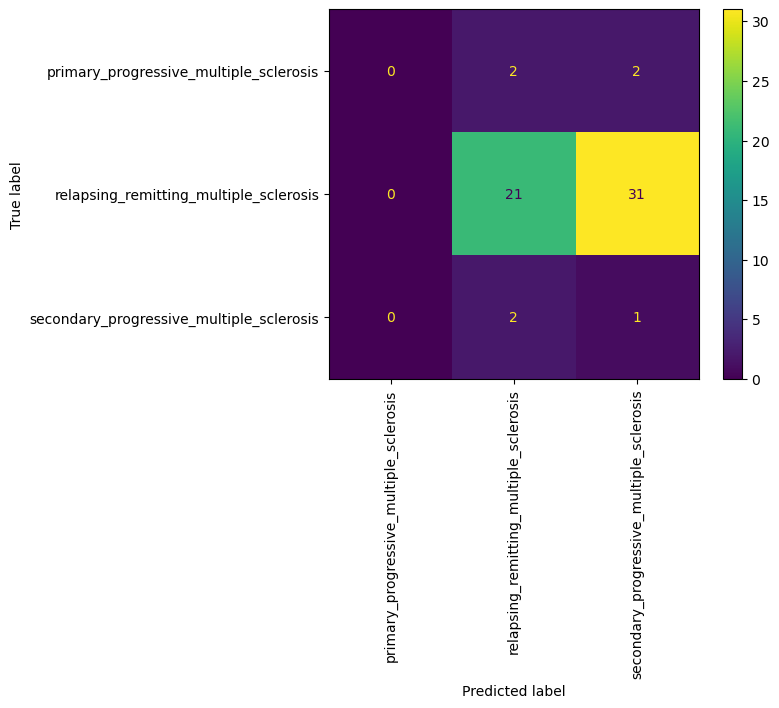

In [71]:
# ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(encoded_dataset["test"]["labels"], test_preds, display_labels=label2id, xticks_rotation="vertical")

In [53]:
# Save model
peft_model.save_pretrained(paths.MODEL_PATH/'peft_medbert_msdiag')

In [54]:
# Load model
config = PeftConfig.from_pretrained(paths.MODEL_PATH/'peft_medbert_msdiag')


class PromptLearningConfig(PeftConfig):
    """
    This is the base configuration class to store the configuration of [`PrefixTuning`], [`PromptEncoder`], or
    [`PromptTuning`].

    Args:
        num_virtual_tokens (`int`): The number of virtual tokens to use.
        token_dim (`int`): The hidden embedding dimension of the base transformer model.
        num_transformer_submodules (`int`): The number of transformer submodules in the base transformer model.
        num_attention_heads (`int`): The number of attention heads in the base transformer model.
        num_layers (`int`): The number of layers in the base transformer model.
    """

    num_virtual_tokens: int = field(default=None, metadata={"help": "Number of virtual tokens"})
    token_dim: int = field(
        default=None, metadata={"help": "The hidden embedding dimension of the base transformer model"}
    )
    num_transformer_submodules: Optional[int] = field(
        default=None, metadata={"help": "Number of transformer submodules"}
    )
    num_attention_heads: Optional[int] = field(default=None, metadata={"help": "Number of attention heads"})
    num_layers: Optional[int] = field(default=None, metadata={"help": "Number of transformer layers"})

configuratio interpretation:
- num_virtual_tokens: number of prefix tokens to append to (each layer?)
- num_transformer_submodules: 1 or 2? for decoder/encoder? or is it number of layers? I think decoder encoder architecture because if it is not set, they set it to 1 except in a Seq2Seq task. And they create embeddings for the virtual tokens only once for each submodule?
- num_layers: to how many layers we should add the prefix tuning?
- The peft model will automatically try to infer all the model specification from model.config in the `get_peft_model()` call. It will also automatically construct the PEFT Model class from the task type: return MODEL_TYPE_TO_PEFT_MODEL_MAPPING[peft_config.task_type](model, peft_config, adapter_name=adapter_name)
- you can add multiple adapters (must be all of same peft type though) to a mode each with their own configurations. You must give them unique names, otherwise gives name "default". Each prompt encoding and the whole process will be done for every single adapter I think. It first prepares the peft config by matching non specified elements with the model config. It then sets up the prompt encoder (_set_up_prompt_encoder(adapter_name)) using the created config for the adapter
- If specification is PROMPT_TUNING we just create a trainable word embeddings matrix. By inserting an init text you can initialize the embedding from the base tokenizer and base model. 
- I think the prompt_token ids are initialized separately from the existing ids for the tokenizer. Because we have a different embedding matrix we can initialize from 0 to 19 say and then put it through, then concatenate the weights again to the embeddings of the base model without the virtual tokens. As they don't have any meaning and we will always have the same order of them (first will be virtual token 0, then 1 etc.) we also don't really neew to match them in the forward pass order will always be same.

``` python
if config.num_transformer_submodules is None:
            config.num_transformer_submodules = 2 if config.task_type == TaskType.SEQ_2_SEQ_LM else 1
total_virtual_tokens = config.num_virtual_tokens * config.num_transformer_submodules
```

```
def _prepare_prompt_learning_config(peft_config, model_config):
    if peft_config.num_layers is None:
        if "num_hidden_layers" in model_config:
            num_layers = model_config["num_hidden_layers"]
        elif "num_layers" in model_config:
            num_layers = model_config["num_layers"]
        elif "n_layer" in model_config:
            num_layers = model_config["n_layer"]
        else:
            raise ValueError("Please specify `num_layers` in `peft_config`")
        peft_config.num_layers = num_layers

    if peft_config.token_dim is None:
        if "hidden_size" in model_config:
            token_dim = model_config["hidden_size"]
        elif "n_embd" in model_config:
            token_dim = model_config["n_embd"]
        elif "d_model" in model_config:
            token_dim = model_config["d_model"]
        else:
            raise ValueError("Please specify `token_dim` in `peft_config`")
        peft_config.token_dim = token_dim

    if peft_config.num_attention_heads is None:
        if "num_attention_heads" in model_config:
            num_attention_heads = model_config["num_attention_heads"]
        elif "n_head" in model_config:
            num_attention_heads = model_config["n_head"]
        elif "num_heads" in model_config:
            num_attention_heads = model_config["num_heads"]
        elif "encoder_attention_heads" in model_config:
            num_attention_heads = model_config["encoder_attention_heads"]
        else:
            raise ValueError("Please specify `num_attention_heads` in `peft_config`")
        peft_config.num_attention_heads = num_attention_heads

    if getattr(peft_config, "encoder_hidden_size", None) is None:
        setattr(peft_config, "encoder_hidden_size", peft_config.token_dim)

    return peft_config
```

prefix tuning forward:
- The prefixes are inserted into the model using the past_key_values which is the cached keys and values of the whole sequence before the current token in the autoregressive generation procedure. Instead of computing these keys and values with a model forward pass, we simply compute them directly with our MLP model. This is also why we need the number of attention heads (as we need a pair for every head).
- The prompt encoder returns num_layers * 2 * token_dim past key values, so for every layer a key and value. Reading this one could think only "one token" (one key value pair) is generated. But later this is reshaped into:

past_key_values = past_key_values.view(
                batch_size,
                peft_config.num_virtual_tokens,
                peft_config.num_layers * 2,
                peft_config.num_attention_heads,
                peft_config.token_dim // peft_config.num_attention_heads,
            )

so we again have num_virtual_tokens as a dimension. This matrix is then permuted and split which I don't know the specifics of but it ensures that it is in the correct format.

def _prefix_tuning_forward(
        self,
        input_ids=None,
        attention_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        **kwargs,
    ):
        batch_size = _get_batch_size(input_ids, inputs_embeds)
        past_key_values = self.get_prompt(batch_size)
        fwd_params = list(inspect.signature(self.base_model.forward).parameters.keys())
        kwargs.update(
            {
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "inputs_embeds": inputs_embeds,
                "output_attentions": output_attentions,
                "output_hidden_states": output_hidden_states,
                "return_dict": return_dict,
                "past_key_values": past_key_values,
            }
        )
        if "past_key_values" in fwd_params:
            return self.base_model(labels=labels, **kwargs)
        else:
            transformer_backbone_name = self.base_model.get_submodule(self.transformer_backbone_name)
            fwd_params = list(inspect.signature(transformer_backbone_name.forward).parameters.keys())
            if "past_key_values" not in fwd_params:
                raise ValueError("Model does not support past key values which are required for prefix tuning.")
            outputs = transformer_backbone_name(**kwargs)
            pooled_output = outputs[1] if len(outputs) > 1 else outputs[0]
            if "dropout" in [name for name, _ in list(self.base_model.named_children())]:
                pooled_output = self.base_model.dropout(pooled_output)
            logits = self.base_model.get_submodule(self.cls_layer_name)(pooled_output)

            loss = None
            if labels is not None:
                if self.config.problem_type is None:
                    if self.base_model.num_labels == 1:
                        self.config.problem_type = "regression"
                    elif self.base_model.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                        self.config.problem_type = "single_label_classification"
                    else:
                        self.config.problem_type = "multi_label_classification"

                if self.config.problem_type == "regression":
                    loss_fct = MSELoss()
                    if self.base_model.num_labels == 1:
                        loss = loss_fct(logits.squeeze(), labels.squeeze())
                    else:
                        loss = loss_fct(logits, labels)
                elif self.config.problem_type == "single_label_classification":
                    loss_fct = CrossEntropyLoss()
                    loss = loss_fct(logits.view(-1, self.base_model.num_labels), labels.view(-1))
                elif self.config.problem_type == "multi_label_classification":
                    loss_fct = BCEWithLogitsLoss()
                    loss = loss_fct(logits, labels)
            if not return_dict:
                output = (logits,) + outputs[2:]
                return ((loss,) + output) if loss is not None else output

            return SequenceClassifierOutput(
                loss=loss,
                logits=logits,
                hidden_states=outputs.hidden_states,
                attentions=outputs.attentions,
            )

def get_prompt(self, batch_size: int, task_ids: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Returns the virtual prompts to use for Peft. Only applicable when using a prompt learning method.
        """
        peft_config = self.active_peft_config
        prompt_encoder = self.prompt_encoder[self.active_adapter]
        prompt_tokens = (
            self.prompt_tokens[self.active_adapter]
            .unsqueeze(0)
            .expand(batch_size, -1)
            .to(prompt_encoder.embedding.weight.device)
        )
        if peft_config.peft_type == PeftType.PREFIX_TUNING:
            prompt_tokens = prompt_tokens[:, : peft_config.num_virtual_tokens]
            if peft_config.inference_mode:
                past_key_values = prompt_encoder.embedding.weight.repeat(batch_size, 1, 1)
            else:
                past_key_values = prompt_encoder(prompt_tokens)
            if self.base_model_torch_dtype is not None:
                past_key_values = past_key_values.to(self.base_model_torch_dtype)
            past_key_values = past_key_values.view(
                batch_size,
                peft_config.num_virtual_tokens,
                peft_config.num_layers * 2,
                peft_config.num_attention_heads,
                peft_config.token_dim // peft_config.num_attention_heads,
            )
            if peft_config.num_transformer_submodules == 2:
                past_key_values = torch.cat([past_key_values, past_key_values], dim=2)
            past_key_values = past_key_values.permute([2, 0, 3, 1, 4]).split(
                peft_config.num_transformer_submodules * 2
            )
            if TRANSFORMERS_MODELS_TO_PREFIX_TUNING_POSTPROCESS_MAPPING.get(self.config.model_type, None) is not None:
                post_process_fn = TRANSFORMERS_MODELS_TO_PREFIX_TUNING_POSTPROCESS_MAPPING[self.config.model_type]
                past_key_values = post_process_fn(past_key_values)
            return past_key_values
        else:
            if peft_config.peft_type == PeftType.MULTITASK_PROMPT_TUNING:
                prompts = prompt_encoder(prompt_tokens, task_ids)
            else:
                if peft_config.inference_mode:
                    prompts = prompt_encoder.embedding.weight.repeat(batch_size, 1, 1)
                else:
                    prompts = prompt_encoder(prompt_tokens)
            return prompts


class PrefixEncoder(torch.nn.Module):
    r"""
    The `torch.nn` model to encode the prefix.

    Args:
        config ([`PrefixTuningConfig`]): The configuration of the prefix encoder.

    Example:

    ```py
    >>> from peft import PrefixEncoder, PrefixTuningConfig

    >>> config = PrefixTuningConfig(
    ...     peft_type="PREFIX_TUNING",
    ...     task_type="SEQ_2_SEQ_LM",
    ...     num_virtual_tokens=20,
    ...     token_dim=768,
    ...     num_transformer_submodules=1,
    ...     num_attention_heads=12,
    ...     num_layers=12,
    ...     encoder_hidden_size=768,
    ... )
    >>> prefix_encoder = PrefixEncoder(config)
    ```

    **Attributes**:
        - **embedding** (`torch.nn.Embedding`) -- The embedding layer of the prefix encoder.
        - **transform** (`torch.nn.Sequential`) -- The two-layer MLP to transform the prefix embeddings if
          `prefix_projection` is `True`.
        - **prefix_projection** (`bool`) -- Whether to project the prefix embeddings.

    Input shape: (`batch_size`, `num_virtual_tokens`)

    Output shape: (`batch_size`, `num_virtual_tokens`, `2*layers*hidden`)
    """

    def __init__(self, config):
        super().__init__()
        self.prefix_projection = config.prefix_projection
        token_dim = config.token_dim
        num_layers = config.num_layers
        encoder_hidden_size = config.encoder_hidden_size
        num_virtual_tokens = config.num_virtual_tokens
        if self.prefix_projection and not config.inference_mode:
            # Use a two-layer MLP to encode the prefix
            self.embedding = torch.nn.Embedding(num_virtual_tokens, token_dim)
            self.transform = torch.nn.Sequential(
                torch.nn.Linear(token_dim, encoder_hidden_size),
                torch.nn.Tanh(),
                torch.nn.Linear(encoder_hidden_size, num_layers * 2 * token_dim),
            )
        else:
            self.embedding = torch.nn.Embedding(num_virtual_tokens, num_layers * 2 * token_dim)

    def forward(self, prefix: torch.Tensor):
        if self.prefix_projection:
            prefix_tokens = self.embedding(prefix)
            past_key_values = self.transform(prefix_tokens)
        else:
            past_key_values = self.embedding(prefix)
        return past_key_values